## FCLA/FNLA Fast.ai Numerical/Computational Linear Algebra

### Lecture 3: New Perspectives on NMF, Randomized SVD
Notes / In-Class Questions

WNixalo - 2018/2/8

Question on section: [Truncated SVD](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb#More-Details)

Given A: `m` x `n` and Q: `m` x `r`; is Q the identity matrix?

A≈QQTA

In [1]:
import torch
import numpy as np

In [27]:
Q = np.eye(3)
print(Q)
print(Q.T)
print(Q @ Q.T)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [26]:
# construct I matrix
Q = torch.eye(3)

# torch matrix multip
# torch.mm(Q, Q.transpose)
Q @ torch.t(Q)


 1  0  0
 0  1  0
 0  0  1
[torch.FloatTensor of size 3x3]

So if A is *approx equal* to Q•Q.T•A .. but *not* equal.. then Q is **not** the identity, but is very close to it.

Oh, right. Q: m x r, **not** m x m... 

If both the columns and rows of Q had been orthonormal, then it would have been the Identity, but only the columns (r) are orthonormal.

Q is a tall, skinny matrix.


---

AW gives range(A). AW has far more rows than columns ==> in practice these columns are approximately orthonormal (v.unlikely to get lin-dep cols when choosing random values).

QR decomposition is foundational to Numerical Linear Algebra.

Q consists of orthonormal columns, R is upper-triangular.

**Calculating Truncated-SVD:**

1\. Compute approximation to range(A). We want Q with r orthonormal columns such that $$A\approx QQ^TA$$

2\. Construct $B = Q^T A$, which is small ($r\times n$)

3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$): $B = S\, Σ V^T$

4\. Since: $$A \approx QQ^TA = Q(S \, ΣV^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx UΣV^T$.

**How to choose $r$?**

If we wanted to get 5 cols from a matrix of 100 cols, (5 topics). As a rule of thumb, let's go for 15 instead. You don't want to explicitly pull exactly the amount you want due to the randomized component being present, so you add some buffer.

Since our projection is approximate, we make it a little bigger than we need.

**Implementing Randomized SVD:**

First we want a randomized range finder.

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True)

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
# newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)

vocab = np.array(vectorizer.get_feature_names())

In [3]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [4]:
# computes an orthonormal matrix whose range approximates the range of A
# power_iteration_normalizer can be safe_sparse_dot (fast but unstable), LU (imbetween), or QR (slow but most accurate)
def randomized_range_finder(A, size, n_iter=5):
    # randomly init our Mat to our size; size: num_cols
    Q = np.random.normal(size=(A.shape[1], size))
    
    # LU decomp (lower triang * upper triang mat)
    # improves accuracy & normalizes
    for i in range(n_iter):
        Q, _ = linalg.lu(A @ Q, permute_l=True)
        Q, _ = linalg.lu(A.T @ Q, permute_l=True)
    
    # QR decomp on A & Q
    Q, _ = linalg.qr(A @ Q, mode='economic')
    return Q

Randomized SVD method:

In [5]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    # number of random columns we're going to create is the number of 
    # columns we want + number of oversamples (extra buffer)
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    
    # project M to the (k + p) dimensional space using basis vectors
    B = Q.T @ M
    
    # compute SVD on the thin matrix: (k + p) wide
    Uhat, s, V = linalg.svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    
    # return the number of components we want from U, s, V
    return U[:, :n_components], s[:n_components], V[:n_components, :]

In [6]:
%time u, s, v = randomized_svd(vectors, 5)

CPU times: user 4.68 s, sys: 2.49 s, total: 7.16 s
Wall time: 5.44 s


In [7]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [8]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'jpeg graphics space pub edu ray mail send']

Computational Complexity for a M`x`N matrix in SVD is $M^2N+N^3$, so Randomized (Truncated?) SVD is a *massive* improvement.

---

2018/3/7

Write a loop to calculate the error of your decomposition as your vary the # of topics. Plot the results.

In [35]:
# 1. how do I calculate decomposition error?:
# I guess I'll use MSE?

# # NumPy:    # https://stackoverflow.com/questions/16774849/mean-squared-error-in-numpy
# def MSEnp(A,B):
#     if type(A) == np.ndarray and type(B) == np.ndarray:
#         return ((A - B) ** 2).mean()
#     else:
#         return np.square((A - B)).mean()

# Scikit-Learn:
from sklearn import metrics
MSE = metrics.mean_squared_error  # usg: mse(A,B)


# 2. Now how to recompose my decomposition?:

%time B = vectors  # original matrix
%time U, S, V = randomized_svd(B, 10) # num_topics = 10

# S is vector of Σ's singular values. Convert back to matrix:
%time Σ = S * np.eye(S.shape[0])

# from SVD formula: A ≈ U@Σ@V.T
%time A = U@Σ@V  ## apparently randomized_svd returns V.T, not V ?


# 3. Finally calculated error I guess:

%time mse_error = MSE(A,B)
print(mse_error)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs
CPU times: user 4.62 s, sys: 2.03 s, total: 6.65 s
Wall time: 4.43 s
CPU times: user 74 µs, sys: 2 µs, total: 76 µs
Wall time: 42 µs
CPU times: user 444 ms, sys: 194 ms, total: 638 ms
Wall time: 394 ms
CPU times: user 435 ms, sys: 224 ms, total: 659 ms
Wall time: 583 ms
0.0068263497623073325


In [60]:
# Im putting way too much effort into this lol
def fib(n):
    if n <= 1:
        return n
    else:
        f1 = 1
        f2 = 0
        for i in range(n):
            t = f1 + f2
            tmp = f2
            f2 += f1
            f1 = tmp
        return t

In [82]:
for i,e in enumerate(num_topics):
    print(f'Topics: {num_topics[i]:>3}    ',
          f'Time: {num_topics[i]:>3}')

Topics:   1     Time:   1
Topics:   2     Time:   2
Topics:   3     Time:   3
Topics:   5     Time:   5
Topics:   8     Time:   8
Topics:  13     Time:  13
Topics:  21     Time:  21
Topics:  34     Time:  34
Topics:  55     Time:  55
Topics:  89     Time:  89
Topics: 144     Time: 144


In [84]:
## Setup
import time

B = vectors
num_topics = [fib(i) for i in range(2,14)]
TnE = []  # time & error


## Loop:
for n_topics in num_topics:
    t0 = time.time()
    U, S, Vt = randomized_svd(B, n_topics)
    Σ = S * np.eye(S.shape[0])
    A = U@Σ@Vt
    TnE.append([time.time() - t0, MSE(A,B)])
    
for i, tne in enumerate(TnE):
    print(f'Topics: {num_topics[i]:>3}    '
          f'Time: {np.round(tne[0],3):>3}    '
          f'Error: {np.round(tne[1],12):>3}')

Topics:   1    Time: 10.306    Error: 0.012774542799
Topics:   2    Time: 6.059    Error: 0.011202491441
Topics:   3    Time: 6.796    Error: 0.010130595402
Topics:   5    Time: 6.148    Error: 0.008617415024
Topics:   8    Time: 5.883    Error: 0.007381466577
Topics:  13    Time: 6.036    Error: 0.006150021022
Topics:  21    Time: 7.312    Error: 0.005167188039
Topics:  34    Time: 6.405    Error: 0.004373025522
Topics:  55    Time: 10.075    Error: 0.003611011115
Topics:  89    Time: 9.624    Error: 0.002845523291
Topics: 144    Time: 12.863    Error: 0.002155064568
Topics: 233    Time: 15.912    Error: 0.001544413065


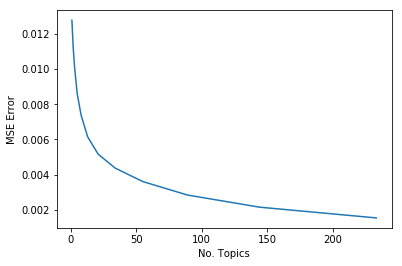

In [85]:
# https://matplotlib.org/users/pyplot_tutorial.html
plt.plot(num_topics, [tne[1] for tne in TnE])
plt.xlabel('No. Topics')
plt.ylabel('MSE Error')
plt.show()

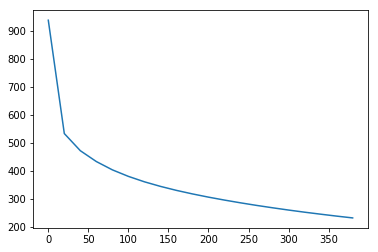

In [87]:
## R.Thomas' class solution:
step = 20
n = 20
error = np.zeros(n)

for i in range(n):
    U, s, V = randomized_svd(vectors, i * step)
    reconstructed = U @ np.diag(s) @ V
    error[i] = np.linalg.norm(vectors - reconstructed)
    
plt.plot(range(0,n*step,step), error)

Looks like she used the Norm instead of MSE. Same curve shape. 

Here's why I used the fibonacci sequence for my topic numbers. This solution took much longer than mine (i=20 vs i=12) with more steps, yet mine appears smoother. Why? I figured this was the shape of curve I'd get: ie interesting bit is in the beginning, so I used a number sequence that spread out as you went so you'd get higher resolution early on. Yay.

---

**NOTE**: random magical superpower Machine Learning Data Analytics *thing*: ***Johnson-Lindenstrauss lemma***: 

basically if you have a matrix with too many columns to work with (leading to overfitting or w/e else), multiple it by some random (square?) matrix and you'll preserve its properties but in a workable shape

https://en.wikipedia.org/wiki/Johnson-Lindenstrauss_lemma